# Librerias

In [1]:
import pandas as pd
import numpy as np
import utils as ut
import matplotlib.pyplot as plt
import lightgbm as lgbm
import sklearn as sk

# Cargar datos

In [2]:
data = pd.read_csv("data/ARIA_cleaned/Sch.csv", index_col="ScheduledActivitySer")

In [3]:
elim = ["Duration", "DefaultDuration"]
data2 = data.drop(columns = elim)

In [4]:
c_categ = ['HistologyCode', 'CityOrTownship', 'EquipmentSer', 'Technique', 'PrimaryPTVSer_isNaN', 'ActivityCategoryCode', 'CalcModelOptions', 'NotificationPriorTimeFlag_x', 'NoEditFlag_x', 'SkinFlashMargin', 'MultiFieldOptFlag', 'Country', 'DiagnosisCode_sec', 'ResourceGroupSer', 'NoFractions_isNaN', 'SummaryStage', 'ObjectStatus_sec', 'PrescribedPercentage', 'DiagnosisCode', 'FractionPatternDigitsPerDay', 'FractionPattern', 'Site', 'MStage', 'Sex', 'StartDelay', 'ScheduledActivityCode', 'NotificationPriorTime_y', 'Intent', 'ObjectStatus_y_4', 'TreatmentIntentType', 'CalcModelOptionsLen', 'Status_x', 'PhaseType', 'Notes', 'Status_y', 'DicomSeqNumber', 'SimulationNeeded', 'TumorSize_isNaN', 'PrescribedDose_isNaN', 'DateOfBirth_isNaN', 'TStage', 'Duration', 'NotificationPriorTimeFlag_y', 'PlanNormMethod', 'NumberOfFractions', 'PlanNormFactor_isNaN', 'Description', 'TreatmentOrientation', 'HistologyCode_sec', 'Priority', 'PatientStatus', 'AssignableFlag', 'ActivityCode', 'NotificationPriorTime_x', 'DefaultDuration', 'NStage', 'ClinicalStatus', 'InterfaceStamp']
c_categ = list(set(c_categ) - set(elim))

# Train/test

In [5]:
le = sk.preprocessing.LabelEncoder()
for i in c_categ:
    data2.loc[:,i] = le.fit_transform( data2[i].astype(str) )

In [6]:
def train_test(data, train_size, target):
    np.random.seed(0)
    i = np.random.choice(range(len(data)), size=round(len(data)*train_size), replace=False)
    j = np.setdiff1d(range(len(data)), i)

    y_tr = data[target].iloc[i]
    y_te = data[target].iloc[j]
    x_tr = data.iloc[i,:].drop(columns = target)
    x_te = data.iloc[j,:].drop(columns = target)

    return (x_tr, y_tr, x_te, y_te, i, j)
    

(x_tr, y_tr, x_te, y_te, i, j) = train_test(data2, 0.75, "ActualDuration")
# (x_tr, y_tr, x_te, y_te, i, j) = train_test(data2, 0.75, "ScheduledDuration")
print(len(x_tr))
print(len(x_te))

14883
4961


In [7]:
train = lgbm.Dataset(x_tr, label = y_tr, categorical_feature = c_categ )
test  = lgbm.Dataset(x_te, label = y_te, categorical_feature = c_categ )

In [8]:
parameters = {
    'objective': 'regression',
    'metric': ['rmse'],
#     'metric': ['poisson'],
    'boosting': 'gbdt',
    'learning_rate': 0.1,
    'verbose': 1,
#     'force_col_wise': 'true',
    
    # params util to prevent overfitting:
#     'feature_fraction': 0.4,
#     'bagging_fraction': 0.4,
#     'bagging_freq': 8,
    'num_leaves': 60,
#     'path_smooth': 10,
#     'lambda_l1': 100,
#     'lambda_l2': 100,
#     'min_data_in_leaf': 10,
#     'max_depth': 20,
    
#     'max_bin': 255,
#     'min_data_in_bin': 3,
}

model = lgbm.train(parameters, train, categorical_feature = c_categ, 
                       valid_sets = [test, ],
                       num_boost_round = 5000,
                       early_stopping_rounds = 200,
                  )
# 4.28

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 14883, number of used features: 57
[LightGBM] [Info] Start training from score 13.401325
[1]	valid_0's rmse: 5.81437
Training until validation scores don't improve for 200 rounds
[2]	valid_0's rmse: 5.62905
[3]	valid_0's rmse: 5.47298
[4]	valid_0's rmse: 5.3355
[5]	valid_0's rmse: 5.2192
[6]	valid_0's rmse: 5.1205
[7]	valid_0's rmse: 5.03293
[8]	valid_0's rmse: 4.95796
[9]	valid_0's rmse: 4.89123
[10]	valid_0's rmse: 4.83685
[11]	valid_0's rmse: 4.79143
[12]	valid_0's rmse: 4.74971
[13]	valid_0's rmse: 4.71234
[14]	valid_0's rmse: 4.68163
[15]	valid_0's rmse: 4.65286
[16]	valid_0's rmse: 4.62697
[17]	valid_0's rmse: 4.60543
[18]	valid_0's rmse: 4.58265

D:\miniconda3\envs\tfm2\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\miniconda3\envs\tfm2\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))



[19]	valid_0's rmse: 4.56602
[20]	valid_0's rmse: 4.55326
[21]	valid_0's rmse: 4.53841
[22]	valid_0's rmse: 4.52827
[23]	valid_0's rmse: 4.51575
[24]	valid_0's rmse: 4.50696
[25]	valid_0's rmse: 4.49866
[26]	valid_0's rmse: 4.48948
[27]	valid_0's rmse: 4.48215
[28]	valid_0's rmse: 4.47091
[29]	valid_0's rmse: 4.46241
[30]	valid_0's rmse: 4.45294
[31]	valid_0's rmse: 4.4417
[32]	valid_0's rmse: 4.43149
[33]	valid_0's rmse: 4.42429
[34]	valid_0's rmse: 4.4208
[35]	valid_0's rmse: 4.41573
[36]	valid_0's rmse: 4.40972
[37]	valid_0's rmse: 4.40693
[38]	valid_0's rmse: 4.40264
[39]	valid_0's rmse: 4.39453
[40]	valid_0's rmse: 4.39116
[41]	valid_0's rmse: 4.38674
[42]	valid_0's rmse: 4.38345
[43]	valid_0's rmse: 4.38027
[44]	valid_0's rmse: 4.37542
[45]	valid_0's rmse: 4.37318
[46]	valid_0's rmse: 4.36773
[47]	valid_0's rmse: 4.36487
[48]	valid_0's rmse: 4.36034
[49]	valid_0's rmse: 4.35808
[50]	valid_0's rmse: 4.35372
[51]	valid_0's rmse: 4.35065
[52]	valid_0's rmse: 4.34693
[53]	valid_0's 

[296]	valid_0's rmse: 4.28993
[297]	valid_0's rmse: 4.28993
[298]	valid_0's rmse: 4.29035
[299]	valid_0's rmse: 4.29082
[300]	valid_0's rmse: 4.29109
[301]	valid_0's rmse: 4.29124
[302]	valid_0's rmse: 4.29124
[303]	valid_0's rmse: 4.29159
[304]	valid_0's rmse: 4.29202
[305]	valid_0's rmse: 4.29209
[306]	valid_0's rmse: 4.29218
[307]	valid_0's rmse: 4.29252
[308]	valid_0's rmse: 4.29233
[309]	valid_0's rmse: 4.29163
[310]	valid_0's rmse: 4.29185
[311]	valid_0's rmse: 4.292
[312]	valid_0's rmse: 4.292
[313]	valid_0's rmse: 4.29184
[314]	valid_0's rmse: 4.29139
[315]	valid_0's rmse: 4.29165
[316]	valid_0's rmse: 4.29177
[317]	valid_0's rmse: 4.2918
[318]	valid_0's rmse: 4.29163
[319]	valid_0's rmse: 4.29165
[320]	valid_0's rmse: 4.29182
[321]	valid_0's rmse: 4.29165
[322]	valid_0's rmse: 4.29203
[323]	valid_0's rmse: 4.29198
[324]	valid_0's rmse: 4.2922
[325]	valid_0's rmse: 4.2914
[326]	valid_0's rmse: 4.29149
[327]	valid_0's rmse: 4.29133
[328]	valid_0's rmse: 4.29129
[329]	valid_0's r

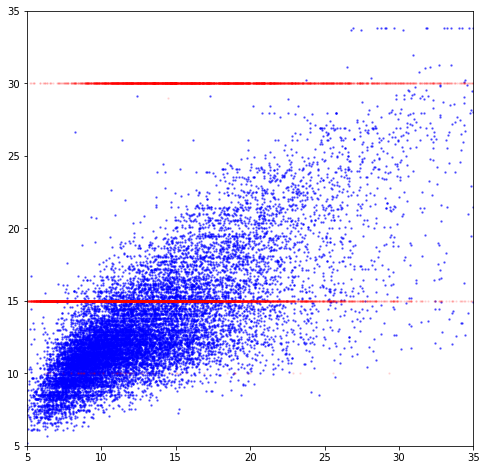

In [9]:
y_pred = model.predict(x_tr)

fig = plt.figure(1, figsize=(8,8))
plt.scatter(y_tr, y_pred, s = 2, alpha = 0.5, color = "blue")
plt.scatter(y_tr, data.ScheduledDuration.iloc[i], s = 2, alpha = 0.1, color = "red")

plt.xlim(5, 35)
plt.ylim(5, 35)
plt.show()

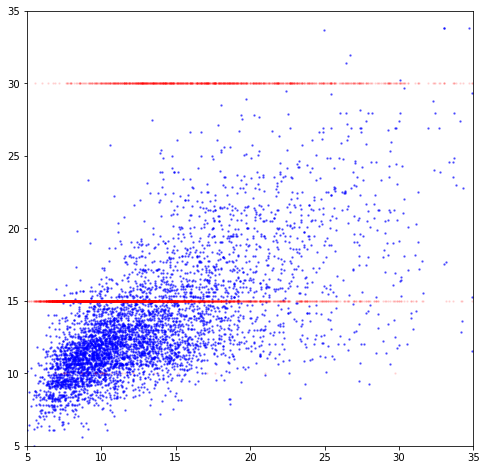

In [10]:
y_pred = model.predict(x_te)

fig = plt.figure(1, figsize=(8,8))
plt.scatter(y_te, y_pred, s=2, alpha = 0.5, color="blue")
plt.scatter(y_te, data.ScheduledDuration.iloc[j], s=2, alpha = 0.1, color="red")

plt.xlim(5, 35)
plt.ylim(5, 35)
plt.show()

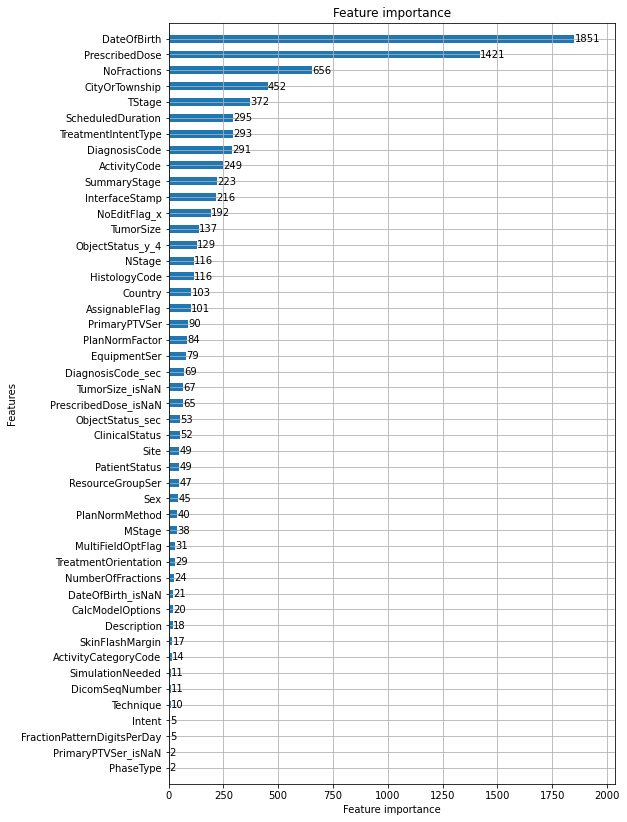

In [11]:
lgbm.plot_importance(model, height=0.5).figure.set_size_inches(8, 14)

<AxesSubplot:>

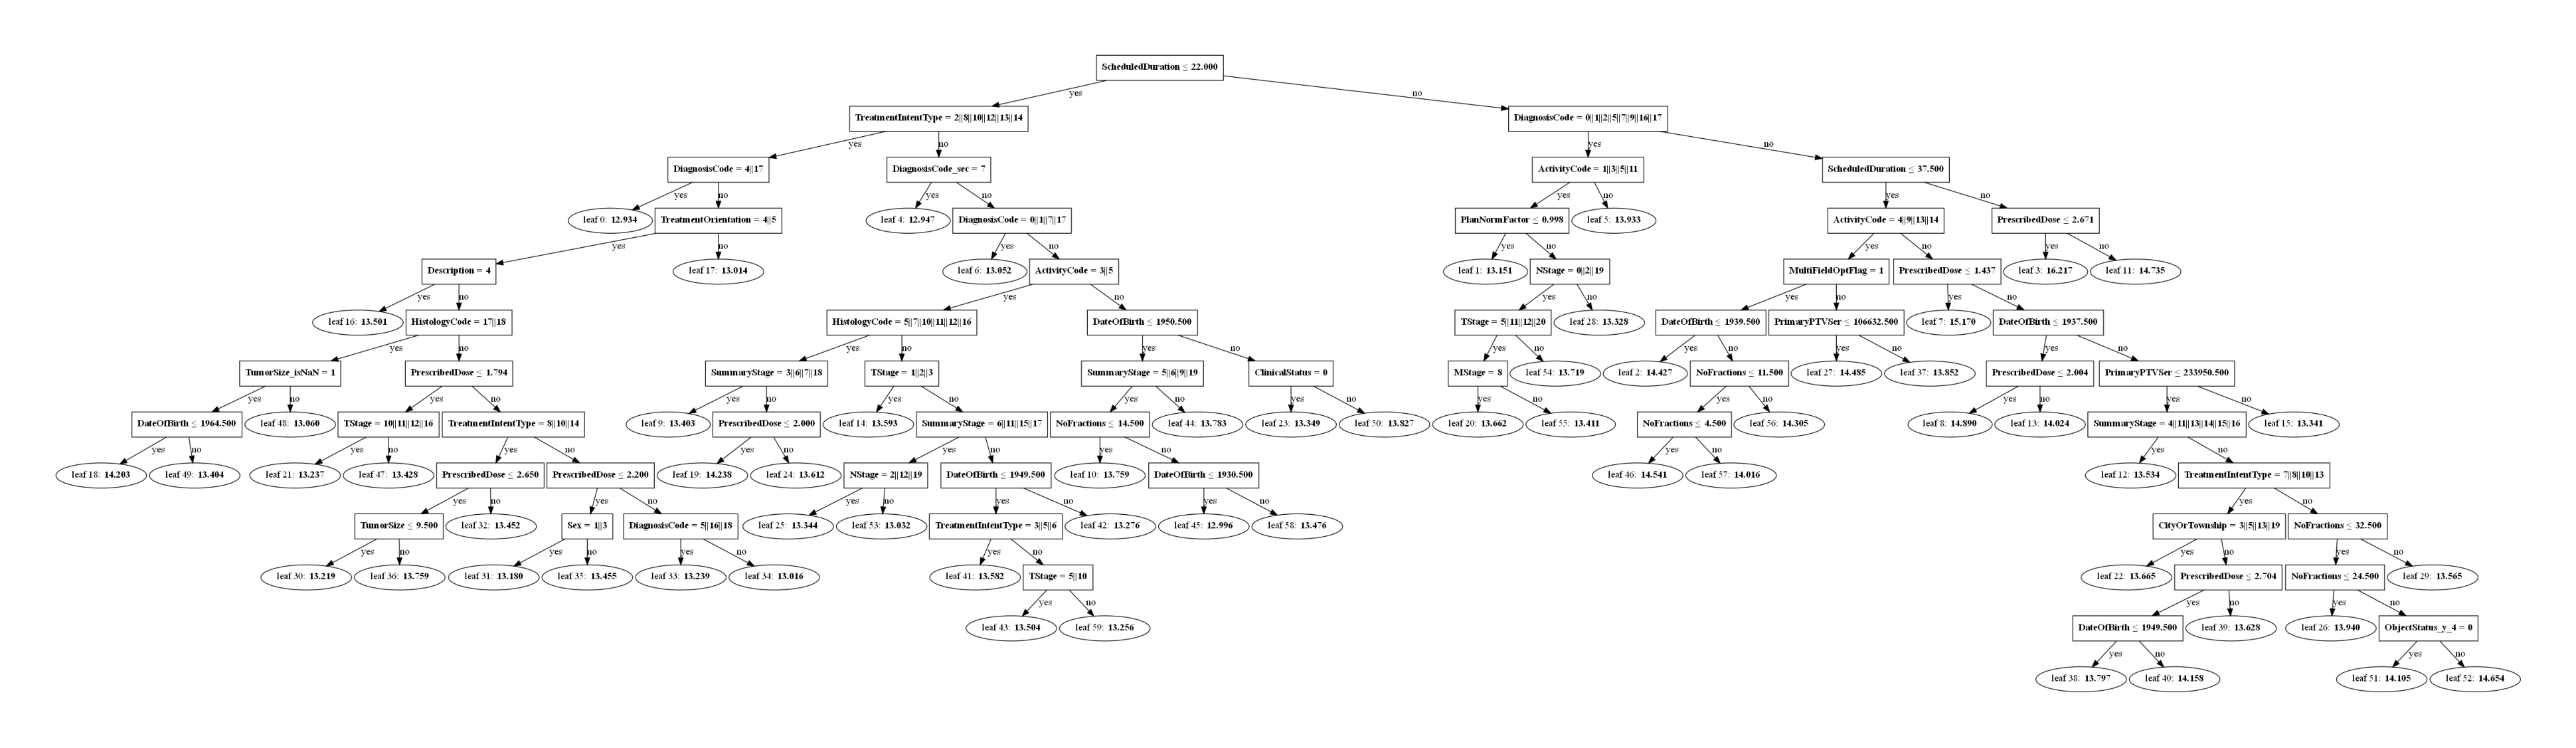

In [12]:
lgbm.plot_tree(model, orientation='vertical', dpi=800)

In [13]:
print(np.mean(y_pred))
print(np.mean(y_te))
print(np.mean(data.ScheduledDuration))

13.439773559689245
13.476674729557214
18.282805885910097


# Ex

In [ ]:
# uno = sch2.real[sch2.ActivityCode=="New Start"]
# dos = sch2.real[sch2.ActivityCode=="Fin Tratamiento"]
# tres= sch2.real
# # cua = sch2.real[sch2.ActivityCode=="Fin Tratamiento"]

# plt.hist(uno, bins=100, range=[0,40], density=True, alpha=0.5, color="red")
# plt.hist(dos, bins=100, range=[0,40], density=True, alpha=0.5, color="blue")
# plt.hist(tres,bins=100, range=[0,40], density=True, alpha=0.5, color="green")
# # plt.hist(cua ,bins=100, range=[0,40], density=True, alpha=0.5, color="yellow")
# plt.show()